# Extended sources in SPIRE maps

This notebook was originally written by Peter Hurley to investigate the possibility of using XID+ to get flux posterior distributions for resolved objects in the far infrared. This is to be done by using fitted profiles from optical images. 

In [1]:
import warnings
from matplotlib.cbook import MatplotlibDeprecationWarning
warnings.simplefilter('ignore', MatplotlibDeprecationWarning)
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore', RuntimeWarning)
warnings.simplefilter('ignore',UnicodeWarning)
#warnings.simplefilter('ignore',VisibleDeprecationWarning)

import numpy as np
import scipy.stats as st
import pylab as plt
from pymoc import MOC

import xidplus
from xidplus.stan_fit import SPIRE
from xidplus import posterior_maps as postmaps

from astropy.io import fits
from astropy import wcs
from astropy.table import Table
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
from astropy.coordinates import SkyCoord
from astropy import units as u

import pickle
import seaborn as sns
import pandas as pd
sns.set(color_codes=True)

%matplotlib inline
import aplpy

In [2]:
hdulist_250=fits.open('./data/XMM-LSS-NEST_image_250_SMAP_v6.0.fits')
im250phdu=hdulist_250[0].header
im250hdu=hdulist_250[1].header
im250=hdulist_250[1].data*1.0E3
nim250=hdulist_250[2].data*1.0E3
w_250 = wcs.WCS(hdulist_250[1].header)
pixsize250=3600.0*w_250.wcs.cd[1,1] #pixel size (in arcseconds)
#hdulist.close()

hdulist_350=fits.open('./data/XMM-LSS-NEST_image_350_SMAP_v6.0.fits')
im350phdu=hdulist_350[0].header
im350hdu=hdulist_350[1].header
im350=hdulist_350[1].data*1.0E3
nim350=hdulist_350[2].data*1.0E3
w_350 = wcs.WCS(hdulist_350[1].header)
pixsize350=3600.0*w_350.wcs.cd[1,1] #pixel size (in arcseconds)
#hdulist.close()

hdulist_500=fits.open('./data/XMM-LSS-NEST_image_500_SMAP_v6.0.fits')
im500phdu=hdulist_500[0].header
im500hdu=hdulist_500[1].header
im500=hdulist_500[1].data*1.0E3
nim500=hdulist_500[2].data*1.0E3
w_500 = wcs.WCS(hdulist_500[1].header)
pixsize500=3600.0*w_500.wcs.cd[1,1] #pixel size (in arcseconds)
#hdulist.close()

In [3]:
source=Table.read('./data/extended_source_test.xml')


In [4]:
IRAC_sources=Table.read('./data/UDS_PACSxID24_v1.fits')

In [5]:
IRAC_sources

XID,RA,Dec,F_PACS_100__A4,F_PACS_100__A5,F_PACS_100__A6,F_PACS_100__A7,F_PACS_100__A8,F_PACS_100__A10,F_PACS_100,Ferr_PACS_100__A4,Ferr_PACS_100__A5,Ferr_PACS_100__A6,Ferr_PACS_100__A7,Ferr_PACS_100__A8,Ferr_PACS_100__A10,Ferr_PACS_100,F_PACS_100__SKY,F_PACS_160__A4,F_PACS_160__A5,F_PACS_160__A6,F_PACS_160__A7,F_PACS_160__A8,F_PACS_160__A10,F_PACS_160,Ferr_PACS_160__A4,Ferr_PACS_160__A5,Ferr_PACS_160__A6,Ferr_PACS_160__A7,Ferr_PACS_160__A8,Ferr_PACS_160__A10,Ferr_PACS_160,F_PACS_160__SKY,HELP_ID
,deg,deg,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy / pix,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy / pix,
int32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str25
35164,33.400427,-3.532034,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,XMM-PACSxID24-UDS-1-00001
69559,33.402787,-3.552514,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,XMM-PACSxID24-UDS-1-00002
69612,33.402787,-3.529534,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,XMM-PACSxID24-UDS-1-00003
35151,33.407827,-3.534404,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,XMM-PACSxID24-UDS-1-00004
35141,33.409607,-3.534104,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,XMM-PACSxID24-UDS-1-00005
35126,33.412387,-3.544484,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,XMM-PACSxID24-UDS-1-00006
69545,33.413037,-3.555364,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,XMM-PACSxID24-UDS-1-00007
69613,33.421437,-3.521034,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,XMM-PACSxID24-UDS-1-00008


In [6]:
WISE_sources=Table.read('./data/WXSC.phot.clean_all.fits')

In [7]:
#Set some color info

cmap=sns.cubehelix_palette(8, start=.5, rot=-.75,as_cmap=True)

vmin=-1.7E1/1.0E3
vmax=4.446e+01/1.0E3
ra_zoom=source['RAJ2000']
dec_zoom=source['DEJ2000']
radius=0.05

In [8]:

c = SkyCoord(ra=ra_zoom, dec=dec_zoom)  
catalog = SkyCoord(ra=WISE_sources['ra'], dec=WISE_sources['dec'])  
idx, d2d, d3d = c.match_to_catalog_sky(catalog)  

In [9]:
WISE_sources[idx]

desig,ra,dec,w1best,w1berr,w1f,w2best,w2berr,w2f,w3best,w3berr,w3f,w4best,w4berr,w4f,W1snr,W2snr,W3snr,W4snr,tile,Riso,R2iso,R3iso,R4iso,ba,pa,flux_1,err_1,mag_1,merr_1,flg1,flux_2,err_2,mag_2,merr_2,flg2,flux_3,err_3,mag_3,merr_3,flg3,flux_4,err_4,mag_4,merr_4,flg4,W1W2,W1W2er,W2W3,W2W3er,W1W3,W1W3er,W3W4,W3W4er,meanSB_1,meanSB_2,meanSB_3,meanSB_4,sky_1,sig_1,sky_2,sig_2,sky_3,sig_3,sky_4,sig_4,SB_1,SB_2,SB_3,SB_4,scale_1a,scale_1b,beta_1a,beta_1b,scale_2a,scale_2b,beta_2a,beta_2b,scale_3a,scale_3b,beta_3a,beta+3b,scale_4a,scale_4b,beta_4a,beta_4b,Rtot_1,ftot_1,ftoterr_1,mtot_1,mterr1,Rtot_2,ftot_2,ftoterr_2,mtot_2,mterr2,Rtot_3,ftot_3,ftoterr_3,mtot_3,mterr3,Rtot_4,ftot_4,ftoterr_4,mtot_4,mterr4,Reff_1,SBeff_1,con_1,Reff_2,SBeff_2,con_2,Reff_3,SBeff_3,con_3,Reff_4,SBeff_4,con_4,R1conv,W1conv,uW1conv,R2conv,W2conv,uW2conv,R3conv,W3conv,uW3conv,R4conv,W4conv,uW4conv,Rinner,Router,w1zero,w2zero,w3zero,w4zero,w1mpro,dw1mpro,w1rchi2,w2mpro,dw2mpro,w2rchi2,w3mpro,dw3mpro,w3rchi2,w4mpro,dw4mpro,w4rchi2,Rw123,w123,dw123,Rw222,w222,dw222,Rw318,w318,dw318,Rw4155,w4155,dw4155,xscprox,Rmoment,Rminor,Rfuzzy,Rfuzz2,Rfuzz3,Rfuzz4,vc,sepmin
,deg,deg,mag,mag,,mag,mag,,mag,mag,,mag,mag,,,,,,,arcsec,arcsec,arcsec,arcsec,,deg,mJy,mJy,mag,mag,,mJy,mJy,mag,mag,,mJy,mJy,mag,mag,,mJy,mJy,mag,mag,,mag,mag,mag,mag,mag,mag,mag,mag,mag.asec,mag.asec,mag.asec,mag.asec,dn,dn,dn,dn,dn,dn,dn,dn,mag.asec,mag.asec,mag.asec,mag.asec,arcsec,arcsec,,,arcsec,arcsec,,,arcsec,arcsec,,,arcsec,arcsec,,,arcsec,mJy,mJy,mag,mag,arcsec,mJy,mJy,mag,mag,arcsec,mJy,mJy,mag,mag,arcsec,mJy,mJy,mag,mag,arcsec,mag.asec,,arcsec,mag.asec,,arcsec,mag.asec,,arcsec,mag.asec,,arcsec,mag,mag,arcsec,mag,mag,arcsec,mag,mag,arcsec,mag,mag,arcsec,arcsec,mag,mag,mag,mag,mag,mag,,mag,mag,,mag,mag,,mag,mag,,arcsec,mag,mag,arcsec,mag,mag,arcsec,mag,mag,arcsec,mag,mag,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,,arcsec
str23,float64,float64,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,float32,float32,str12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,int32,float64,float64,float64,float64,int32,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,int32,float32
J022136.46-053116.6,35.40201,-5.52123,8.979,0.011,0,8.937,0.02,0,5.594,0.022,10,3.942,0.048,10,98.7,90.5,50.4,22.7,S_tile_133,122.19,108.57,93.53,82.59,0.69,116.9,79.337,0.84,8.979,0.011,1,44.7,0.49,8.955,0.012,1,152.26,1.76,5.701,0.013,1,183.888,3.69,4.079,0.022,1,0.042,0.017,3.253,0.017,3.296,0.017,1.688,0.027,17.298,17.263,14.384,13.213,2.169,0.056,5.949,0.061,345.36,0.71,27.182,0.07,23.624,22.536,18.371,15.892,8.05,46.92,0.73,0.61,7.93,46.91,0.89,0.61,10.03,58.85,0.77,0.5,8.6,52.22,0.82,0.52,183.28,80.71,0.831,8.96,0.011,183.28,45.477,0.562,8.936,0.013,218.77,168.042,3.332,5.594,0.022,194.61,208.533,9.172,3.942,0.048,40.6,18.596,3.14,39.5,18.513,3.08,45.4,15.475,2.72,48.2,13.951,2.39,122.19,8.979,0.011,108.57,8.955,0.012,93.53,5.701,0.013,99.0,3.985,0.025,153.2,199

In [10]:
def extended_source(beta,r_e,x_0,y_0,x,y):
    source_grid=np.exp(-beta*((x-x_0)**2+(y-y_0)**2)/r_e)
    return source_grid

In [11]:
xx, yy = np.meshgrid(np.arange(0,101), np.arange(0,101), sparse=True)


The extended source as seen in optical, MIPS, WISE band 4, and the SPIRE bands

In [12]:
source

Field,ID2MASX,RAJ2000,DEJ2000,supRAdeg,supDEdeg,density,r_K20e,J_K20e,e_J_K20e,f_J_K20e,H_K20e,e_H_K20e,f_H_K20e,K_K20e,e_K_K20e,f_K_K20e,Kb_a,Kpa,Sb_a,Spa,r_ext,J_ext,e_J_ext,H_ext,e_H_ext,K_ext,e_K_ext,cc
,,deg,deg,deg,deg,,arcs,mag,mag,,mag,mag,,mag,mag,,,deg,,deg,arcs,mag,mag,mag,mag,mag,mag,
object,object,float64,float64,float64,float64,float64,float64,float64,float64,int16,float64,float64,int16,float64,float64,int16,float64,int16,float64,int16,float64,float64,float64,float64,float64,float64,float64,object
XMM-LSS,02213646-0531170,35.401958,-5.5213939999999999,35.401961999999997,-5.5213799999999997,2.5499999999999998,51.0,10.523999999999999,0.024,0,9.9870000000000001,0.040000000000000001,0,9.6880000000000006,0.050999999999999997,0,0.66000000000000003,-60,0.47999999999999998,-70,86.959999999999994,10.145,0.024,9.7349999999999994,0.040000000000000001,9.4049999999999994,0.050999999999999997,0


In [13]:
def sersic(alpha,beta,x_0,y_0,x,y):
    source_grid=np.exp(-1*((((x-x_0)**2+(y-y_0)**2)**0.5)/alpha)**(1/beta))
    return source_grid
    

def extended_source(beta,r_e,x_0,y_0,x,y):
    source_grid=np.exp(-beta*((x-x_0)**2+(y-y_0)**2)/r_e)
    return source_grid

In [14]:
bulge=sersic(WISE_sources[idx]['scale_1a'],WISE_sources[idx]['beta_1a'],50,50,xx,yy) #Raphael added first 50 to make it run
disc=sersic(WISE_sources[idx]['scale_1b'],WISE_sources[idx]['beta_1b'],50,50,xx,yy)

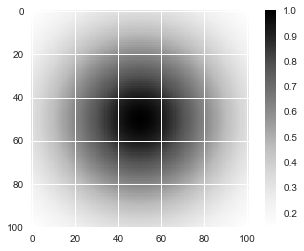

In [15]:
plt.imshow(disc)
plt.colorbar()

In [16]:
#pixsize array (size of pixels in arcseconds)
pixsize=np.array([pixsize250,pixsize350,pixsize500])
#point spread function for the three bands
prfsize=np.array([18.15,25.15,36.3])


##---------fit using Gaussian beam-----------------------
prf250=Gaussian2DKernel(prfsize[0]/2.355,x_size=101,y_size=101)
prf250.normalize(mode='peak')
prf350=Gaussian2DKernel(prfsize[1]/2.355,x_size=101,y_size=101)
prf350.normalize(mode='peak')
prf500=Gaussian2DKernel(prfsize[2]/2.355,x_size=101,y_size=101)
prf500.normalize(mode='peak')

pind250=np.arange(0,101,1)*1.0/pixsize[0] #get 250 scale in terms of pixel scale of map
pind350=np.arange(0,101,1)*1.0/pixsize[1] #get 350 scale in terms of pixel scale of map
pind500=np.arange(0,101,1)*1.0/pixsize[2] #get 500 scale in terms of pixel scale of map

#convolved250 = convolve(prf250)[::6,::6]

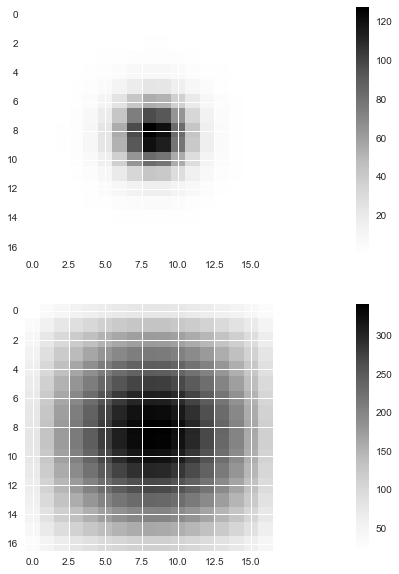

In [17]:
fig=plt.figure(figsize=(30,10))
plt.subplot(2,1,1)
plt.imshow(convolve(bulge,prf250.array)[::6,::6],interpolation='nearest')
plt.colorbar()
plt.subplot(2,1,2)
plt.imshow(convolve(disc,prf250.array)[::6,::6],interpolation='nearest')
plt.colorbar()

In [18]:
w_250.wcs_world2pix(ra_zoom,dec_zoom,0)

[array([ 1605.60172062]), array([ 1167.31004696])]

In [19]:
def radial_profile(data, center):
    x, y = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile 

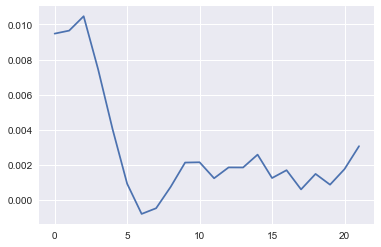

In [20]:

rad_profile = radial_profile(hdulist_250[1].data,w_250.wcs_world2pix(ra_zoom,dec_zoom,0))

fig, ax = plt.subplots()
plt.plot(rad_profile[0:22], 'x-')

# Fit extended source with XID+

In [21]:
RA=np.concatenate((IRAC_sources['RA'].__array__(),source['RAJ2000'].__array__()))
Dec=np.concatenate((IRAC_sources['Dec'].__array__(),source['DEJ2000'].__array__()))

In [22]:
source

Field,ID2MASX,RAJ2000,DEJ2000,supRAdeg,supDEdeg,density,r_K20e,J_K20e,e_J_K20e,f_J_K20e,H_K20e,e_H_K20e,f_H_K20e,K_K20e,e_K_K20e,f_K_K20e,Kb_a,Kpa,Sb_a,Spa,r_ext,J_ext,e_J_ext,H_ext,e_H_ext,K_ext,e_K_ext,cc
,,deg,deg,deg,deg,,arcs,mag,mag,,mag,mag,,mag,mag,,,deg,,deg,arcs,mag,mag,mag,mag,mag,mag,
object,object,float64,float64,float64,float64,float64,float64,float64,float64,int16,float64,float64,int16,float64,float64,int16,float64,int16,float64,int16,float64,float64,float64,float64,float64,float64,float64,object
XMM-LSS,02213646-0531170,35.401958,-5.5213939999999999,35.401961999999997,-5.5213799999999997,2.5499999999999998,51.0,10.523999999999999,0.024,0,9.9870000000000001,0.040000000000000001,0,9.6880000000000006,0.050999999999999997,0,0.66000000000000003,-60,0.47999999999999998,-70,86.959999999999994,10.145,0.024,9.7349999999999994,0.040000000000000001,9.4049999999999994,0.050999999999999997,0


In [23]:
prior_cat='IRAC'
#---prior250--------
prior250=xidplus.prior(im250,nim250,im250phdu,im250hdu)#Initialise with map, uncertianty map, wcs info and primary header
prior250.prior_cat(RA,Dec,prior_cat)#Set input catalogue
prior250.prior_bkg(-5.0,5)#Set prior on background (assumes Guassian pdf with mu and sigma)
#---prior350--------
prior350=xidplus.prior(im350,nim350,im350phdu,im350hdu)
prior350.prior_cat(RA,Dec,prior_cat)
prior350.prior_bkg(-5.0,5)

#---prior500--------
prior500=xidplus.prior(im500,nim500,im500phdu,im500hdu)
prior500.prior_cat(RA,Dec,prior_cat)
prior500.prior_bkg(-5.0,5)

In [24]:
#pixsize array (size of pixels in arcseconds)
pixsize=np.array([pixsize250,pixsize350,pixsize500])
#point response function for the three bands
prfsize=np.array([18.15,25.15,36.3])
#use Gaussian2DKernel to create prf (requires stddev rather than fwhm hence pfwhm/2.355)
from astropy.convolution import Gaussian2DKernel

##---------fit using Gaussian beam-----------------------
prf250=Gaussian2DKernel(prfsize[0]/2.355,x_size=101,y_size=101)
prf250.normalize(mode='peak')
prf350=Gaussian2DKernel(prfsize[1]/2.355,x_size=101,y_size=101)
prf350.normalize(mode='peak')
prf500=Gaussian2DKernel(prfsize[2]/2.355,x_size=101,y_size=101)
prf500.normalize(mode='peak')

pind250=np.arange(0,101,1)*1.0/pixsize[0] #get 250 scale in terms of pixel scale of map
pind350=np.arange(0,101,1)*1.0/pixsize[1] #get 350 scale in terms of pixel scale of map
pind500=np.arange(0,101,1)*1.0/pixsize[2] #get 500 scale in terms of pixel scale of map

prior250.set_prf(prf250.array,pind250,pind250)#requires psf as 2d grid, and x and y bins for grid (in pixel scale)
prior350.set_prf(prf350.array,pind350,pind350)
prior500.set_prf(prf500.array,pind500,pind500)

In [25]:
print( 'fitting ' + str(prior250.nsrc)+' sources \n')
print( 'using ' +  str(prior250.snpix)+', '+ str(prior250.snpix)+' and '+ str(prior500.snpix)+' pixels')


fitting 69615 sources 

using 3380938, 3380938 and 845235 pixels


In [26]:

moc=MOC()
moc.read('./data/extended_source_test_MOC_rad4.fits')
prior250.set_tile(moc)
prior350.set_tile(moc)
prior500.set_tile(moc)

In [27]:
print( 'fitting '+ str(prior250.nsrc)+' sources \n')
print( 'using ' +  str(prior250.snpix)+', '+ str(prior350.snpix)+' and '+ str(prior500.snpix)+' pixels')


fitting 127 sources 

using 5488, 2843 and 1372 pixels


In [28]:
prior250.get_pointing_matrix()
prior350.get_pointing_matrix()
prior500.get_pointing_matrix()

In [29]:
prior250.upper_lim_map()
prior350.upper_lim_map()
prior500.upper_lim_map()

In [30]:

fit=SPIRE.all_bands(prior250,prior350,prior500,iter=1500)

/XID+SPIRE found. Reusing


In [31]:
posterior=xidplus.posterior_stan(fit,[prior250,prior350,prior500])


In [32]:


hdurep_250=postmaps.make_fits_image(prior250,prior250.sim)
hdurep_350=postmaps.make_fits_image(prior350,prior350.sim)
hdurep_500=postmaps.make_fits_image(prior500,prior500.sim)

In [33]:


rep_maps=postmaps.replicated_maps([prior250, prior350, prior500],posterior,nrep=1000)


In [34]:
rep_maps

[array([[ -95.15871186,    9.6646541 ,   34.23258716, ...,   29.78146418,
           40.43826205,    9.09151328],
        [  -4.14585848,   53.19359969,   45.58618774, ...,   -9.70311013,
           11.07712368,   12.44218295],
        [  35.50114991,   -3.95510777,   28.21229014, ...,   21.85292699,
           -9.18307466,  -51.6020461 ],
        ..., 
        [ -31.0917198 ,   -5.93654978,  -13.14994426, ...,   24.74482587,
          -30.42967735,   51.2439061 ],
        [  50.61248221,   43.46473732,  -39.25446508, ...,  -25.02145441,
          -83.14067442,   19.43890849],
        [  17.27912463,   81.72239003,   25.24546498, ...,  110.85676235,
           13.1622351 ,  -18.95470862]]),
 array([[ 16.42307081, -25.45516102,  24.95580806, ...,  33.55797915,
          17.08750418, -54.3404259 ],
        [ 15.94924226, -45.87654087, -20.24761076, ...,  32.45133213,
          61.57367422, -13.68679266],
        [ -7.16009502,  31.23172322, -76.75048209, ...,  48.1314199 ,
          38.2

In [35]:
mod_map_250 = rep_maps[0]
mod_map_350 = rep_maps[1]
mod_map_500 = rep_maps[2]
mod_map_array_250 = rep_maps[0]
mod_map_array_350 = rep_maps[1]
mod_map_array_500 = rep_maps[2]

In [ ]:


pval_250=np.empty_like(prior250.sim)
for i in range(0,prior250.snpix):
    ind=mod_map_array_250[i,:]<prior250.sim[i]
    pval_250[i]=st.norm.ppf(sum(ind)/np.float(mod_map_array_250.shape[1]))
pval_250[np.isposinf(pval_250)]=6
    
pval_350=np.empty_like(prior350.sim)
for i in range(0,prior350.snpix):
    ind=mod_map_array_350[i,:]<prior350.sim[i]
    pval_350[i]=st.norm.ppf(sum(ind)/np.float(mod_map_array_350.shape[1]))
pval_350[np.isposinf(pval_350)]=6
    
pval_500=np.empty_like(prior500.sim)
for i in range(0,prior500.snpix):
    ind=mod_map_array_500[i,:]<prior500.sim[i]
    pval_500[i]=st.norm.ppf(sum(ind)/np.float(mod_map_array_500.shape[1]))
pval_500[np.isposinf(pval_500)]=6

In [ ]:
cmap=sns.cubehelix_palette(8, start=.5, rot=-.75,as_cmap=True)

vmin=-1.7E1/1.0E3
vmax=4.446e+01/1.0E3
ra_zoom=source['RAJ2000']
dec_zoom=source['DEJ2000']
radius=0.05
fig = plt.figure(figsize=(30,30))
cfhtls=aplpy.FITSFigure('./data/W1+1+2.U.11023_11534_3064_3575.fits',figure=fig,subplot=(3,3,1))
cfhtls.show_colorscale(vmin=-10,vmax=200,cmap=cmap)
cfhtls.recenter(ra_zoom, dec_zoom, radius=radius)


mips=aplpy.FITSFigure('./data/wp4_xmm-lss_mips24_map_v1.0.fits.gz',figure=fig,subplot=(3,3,2))
mips.show_colorscale(vmin=-0.001,vmax=5,cmap=cmap)
mips.recenter(ra_zoom, dec_zoom, radius=radius)

wise_band4=aplpy.FITSFigure('./data/L3a-0349m061_ac51-0349m061_ac51-w4-int-3_ra35.401958_dec-5.5213939_asec600.000.fits',figure=fig,subplot=(3,3,3))
wise_band4.show_colorscale(vmin=202,vmax=204,cmap=cmap)
wise_band4.recenter(ra_zoom, dec_zoom, radius=radius)
wise_band4.show_ellipses(ra_zoom, dec_zoom,2*WISE_sources[idx]['Riso']/3600.0,2*WISE_sources[idx]['Riso']*WISE_sources[idx]['ba']/3600.0, angle=360.0-WISE_sources[idx]['pa'],edgecolor='white',linewidth=2.0)


real_250 = aplpy.FITSFigure(hdulist_250[1],figure=fig,subplot=(3,3,4))
real_250.show_colorscale(vmin=vmin,vmax=0.8,cmap=cmap)
#real_250.show_markers(ra_list,dec_list, edgecolor='white', facecolor='white',
                #marker='o', s=40, alpha=0.5)
real_250.show_markers(IRAC_sources['RA'],IRAC_sources['DEC'], edgecolor='yellow', facecolor='yellow',
                marker='o', s=40, alpha=0.5)
real_250.recenter(ra_zoom, dec_zoom, radius=radius)
real_250.show_ellipses(ra_zoom, dec_zoom,2*source['r_K20e']/3600.0,2*source['r_K20e']*source['Kb_a']/3600.0, angle=360.0-source['Spa'],edgecolor='white',linewidth=2.0)
real_250.show_ellipses(ra_zoom, dec_zoom,2*WISE_sources[idx]['Riso']/3600.0,2*WISE_sources[idx]['Riso']*WISE_sources[idx]['ba']/3600.0, angle=360.0-WISE_sources[idx]['pa'],edgecolor='white',linewidth=2.0)

real_250.add_colorbar()
#real_250.show_markers(WISE_sources['ra'],WISE_sources['dec'], edgecolor='red', facecolor='red',
#                marker='o', s=40, alpha=0.5)

real_350 = aplpy.FITSFigure(hdulist_350[1],figure=fig,subplot=(3,3,5))
real_350.show_colorscale(vmin=vmin,vmax=0.8,cmap=cmap)
real_350.show_ellipses(ra_zoom, dec_zoom,2*source['r_K20e']/3600.0,2*source['r_K20e']*source['Kb_a']/3600.0, angle=360.0-source['Spa'],edgecolor='white',linewidth=2.0)

#real_350.show_markers(prior250.sra, prior250.sdec, edgecolor='black', facecolor='black',
                #marker='o', s=40, alpha=0.5)
real_350.recenter(ra_zoom, dec_zoom, radius=radius)

real_500 = aplpy.FITSFigure(hdulist_500[1],figure=fig,subplot=(3,3,6))
real_500.show_colorscale(vmin=vmin,vmax=0.8,cmap=cmap)
#real_500.show_markers(prior250.sra, prior250.sdec, edgecolor='black', facecolor='black',
                #marker='o', s=40, alpha=0.5)
real_500.recenter(ra_zoom, dec_zoom, radius=radius)
real_500.show_ellipses(ra_zoom, dec_zoom,2*source['r_K20e']/3600.0,2*source['r_K20e']*source['Kb_a']/3600.0, angle=360.0-source['Spa'],edgecolor='white',linewidth=2.0)

vmin=-6
vmax=6
cmap=sns.diverging_palette(220, 20,as_cmap=True)

res250=aplpy.FITSFigure(hdurep_250[1],figure=fig,subplot=(3,3,7))
res250.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res250.show_markers(prior250.sra, prior250.sdec, edgecolor='black', facecolor='black',
                marker='o', s=80, alpha=0.5)
res250.recenter(ra_zoom, dec_zoom, radius=radius)

res350=aplpy.FITSFigure(hdurep_350[1],figure=fig,subplot=(3,3,8))
res350.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res350.show_markers(prior350.sra, prior350.sdec, edgecolor='black', facecolor='black',
                marker='o', s=80, alpha=0.5)
res350.recenter(ra_zoom, dec_zoom, radius=radius)


res500=aplpy.FITSFigure(hdurep_500[1],figure=fig,subplot=(3,3,9))
res500.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res500.show_markers(prior500.sra, prior500.sdec, edgecolor='black', facecolor='black',
                marker='o', s=80, alpha=0.5)


res250._data[prior250.sy_pix-np.min(prior250.sy_pix)-1,prior250.sx_pix-np.min(prior250.sx_pix)-1]=pval_250
res350._data[prior350.sy_pix-np.min(prior350.sy_pix)-1,prior350.sx_pix-np.min(prior350.sx_pix)-1]=pval_350
res500._data[prior500.sy_pix-np.min(prior500.sy_pix)-1,prior500.sx_pix-np.min(prior500.sx_pix)-1]=pval_500
res500.recenter(ra_zoom, dec_zoom, radius=radius)
#res500.tick_labels.set_xformat('dd.dd')
#res500.tick_labels.set_yformat('dd.dd')


res250.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res350.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res500.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res250.add_colorbar()
res250.colorbar.set_location('top')
res350.add_colorbar()
res350.colorbar.set_location('top')
res500.add_colorbar()
res500.colorbar.set_location('top')


In [ ]:
def ellipse(x,y,x0,y0,angle,a,b):
    dx=x-x0
    dy=y-y0
    rad=((dx*np.cos(angle)-dy*np.sin(angle))/a)**2 + ((dx*np.sin(angle)+dy*np.cos(angle))/b)**2
    rad[rad<1.0]=1.0
    rad[rad>1.0]=0.0
    return rad
                                                                 
from astropy.modeling.models import Sersic2D

mod = Sersic2D(amplitude = 1, r_eff = 25, n=4, x_0=50, y_0=50,
               ellip=.5, theta=-1)

In [ ]:
wcs_temp = wcs.WCS(prior250.imhdu)
source_pix_x,source_pix_y=wcs_temp.all_world2pix(ra_zoom,dec_zoom,0)

In [ ]:
a=WISE_sources[idx]['Riso']/pixsize[0]
b=WISE_sources[idx]['ba']*a
xx, yy = np.meshgrid(np.arange(0,WISE_sources[idx]['Riso']*3), np.arange(0,WISE_sources[idx]['Riso']*3))


In [ ]:
import scipy.signal as signal
extended_source_SMAP=signal.convolve(ellipse(xx,yy,xx.shape[1]/2.0,yy.shape[0]/2.0,WISE_sources[idx]['pa']*np.pi/180.0,a*pixsize[0],b*pixsize[0]),prf250.array,mode='same')

In [ ]:
plt.imshow(extended_source_SMAP)

In [ ]:
from astropy.modeling.models import Ellipse2D
from astropy.coordinates import Angle

theta = Angle(-1*WISE_sources[idx]['pa'], 'deg')
e = Ellipse2D(amplitude=100., x_0=xx.shape[1]/2.0,y_0=yy.shape[0]/2.0, a=a*pixsize[0], b=b*pixsize[0],
              theta=theta.radian)
plt.imshow(signal.convolve(e(xx,yy),prf250.array,mode='same'))

In [ ]:
from astropy.modeling.models import Sersic2D

mod = Sersic2D(amplitude = 1.0, r_eff = WISE_sources[idx]['scale_1b'], n=WISE_sources[idx]['beta_1b']	,x_0=xx.shape[1]/2.0,y_0=yy.shape[0]/2.0,
               ellip=1.0-WISE_sources[idx]['ba'], theta=theta.radian)
plt.imshow(signal.convolve(mod(xx,yy),prf250.array,mode='same'))

In [ ]:
pind250_source=np.arange(0,WISE_sources[idx]['Riso']*3)*1.0/pixsize[0]

In [ ]:
ipx=source_pix_x+xx*1.0/pixsize[0]-pind250_source[-1]/2
ipy=source_pix_y+yy*1.0/pixsize[0]-pind250_source[-1]/2
from scipy import interpolate
atemp = interpolate.griddata((ipx.ravel(), ipy.ravel()),extended_source_SMAP.ravel(), (prior250.sx_pix,prior250.sy_pix),
                                             method='nearest')

In [ ]:
def add_sersic_source(prior,source_no,angle,scale,beta,ba):
    from astropy.modeling.models import Sersic2D
    from astropy.coordinates import Angle
    import scipy.signal as signal


    import scipy.signal as signal
    wcs_temp = wcs.WCS(prior.imhdu)
    source_pix_x=prior.sx[source_no]
    source_pix_y=prior.sy[source_no]
    pixsize=np.absolute(prior.imhdu['CD2_2']*3600.0)

    mesh_length=np.max([prior.pindx.size,scale*5])
    xx, yy = np.meshgrid(np.arange(0,mesh_length), np.arange(0,mesh_length))
    theta = Angle(-1*angle, 'deg')

    mod = Sersic2D(amplitude = 1.0, r_eff =scale, n=beta,x_0=xx.shape[1]/2.0,y_0=yy.shape[0]/2.0,
               ellip=1.0-ba, theta=theta.radian)
    extended_source_SMAP=signal.convolve(mod(xx,yy),prior.prf,mode='same')
    pind_source=np.arange(0,mesh_length)*1.0/pixsize
    ipx=source_pix_x+xx*1.0/pixsize-pind_source[-1]/2
    ipy=source_pix_y+yy*1.0/pixsize-pind_source[-1]/2
    from scipy import interpolate
    atemp = interpolate.griddata((ipx.ravel(), ipy.ravel()),extended_source_SMAP.ravel(), (prior.sx_pix,prior.sy_pix),
                                             method='nearest')
    ind=atemp>0.001
    ind_not_prev=prior.amat_col != source_no
    prior.amat_data=np.append(prior.amat_data[ind_not_prev],atemp[ind])
    prior.amat_col=np.append(prior.amat_col[ind_not_prev],np.full(ind.sum(),source_no))
    prior.amat_row=np.append(prior.amat_row[ind_not_prev],np.arange(0,prior.snpix,dtype=int)[ind])
    return prior

    
def add_extended_source(prior,source_no,angle,semi_major,semi_minor):
    import scipy.signal as signal
    wcs_temp = wcs.WCS(prior.imhdu)
    source_pix_x=prior.sx[source_no]
    source_pix_y=prior.sy[source_no]
    pixsize=np.absolute(prior.imhdu['CD2_2']*3600.0)
    a=semi_major/pixsize
    b=semi_minor/pixsize
    xx, yy = np.meshgrid(np.arange(0,semi_major*2.5), np.arange(0,semi_major*2.5))
    extended_source_SMAP=signal.convolve(ellipse(xx,yy,xx.shape[1]/2.0,yy.shape[0]/2.0,angle*np.pi/180.0,a*pixsize,b*pixsize),prior.prf,mode='same')
    pind_source=np.arange(0,semi_major*2.5)*1.0/pixsize
    ipx=source_pix_x+xx*1.0/pixsize-pind_source[-1]/2
    ipy=source_pix_y+yy*1.0/pixsize-pind_source[-1]/2
    from scipy import interpolate
    atemp = interpolate.griddata((ipx.ravel(), ipy.ravel()),extended_source_SMAP.ravel(), (prior.sx_pix,prior.sy_pix),
                                             method='nearest')
    ind=atemp>0.001
    ind_not_prev=prior.amat_col != source_no
    prior.amat_data=np.append(prior.amat_data[ind_not_prev],atemp[ind])
    prior.amat_col=np.append(prior.amat_col[ind_not_prev],np.full(ind.sum(),source_no))
    prior.amat_row=np.append(prior.amat_row[ind_not_prev],np.arange(0,prior.snpix,dtype=int)[ind])
    return prior

    

In [ ]:
prior250.pindx.size

In [ ]:
prior250.imhdu['CD2_2']*3600.0

In [ ]:
extended_source_conv=postmaps.make_fits_image(prior250,atemp)


In [ ]:
vmin=-1.7E1/1.0E3
vmax=4.446e+01/1.0E3
cmap=sns.cubehelix_palette(8, start=.5, rot=-.75,as_cmap=True)
real_250 = aplpy.FITSFigure(extended_source_conv[1])
real_250.show_colorscale(vmin=vmin,vmax=0.8,cmap=cmap)
#real_250.show_markers(ra_list,dec_list, edgecolor='white', facecolor='white',
                #marker='o', s=40, alpha=0.5)
real_250.show_ellipses(ra_zoom, dec_zoom,2*WISE_sources[idx]['Riso']/3600.0,2*WISE_sources[idx]['Riso']*WISE_sources[idx]['ba']/3600.0, angle=360.0-WISE_sources[idx]['pa'],edgecolor='white',linewidth=2.0)

real_250.show_markers(IRAC_sources['RA'],IRAC_sources['DEC'], edgecolor='yellow', facecolor='yellow',
                marker='o', s=40, alpha=0.5)
#real_250.recenter(ra_zoom, dec_zoom, radius=radius)
real_250.add_colorbar()

In [ ]:
prior250.amat_data

# Fit with disc and bulge

In [ ]:
#Concatenate the extended source twice, once for bulge once for disc
RA=np.concatenate((np.concatenate((IRAC_sources['RA'].__array__(),source['RAJ2000'].__array__())),source['RAJ2000'].__array__()))
Dec=np.concatenate((np.concatenate((IRAC_sources['DEC'].__array__(),source['DEJ2000'].__array__())),source['DEJ2000'].__array__()))


In [ ]:
prior_cat='IRAC'
#---prior250--------
prior250=xidplus.prior(im250,nim250,im250phdu,im250hdu)#Initialise with map, uncertianty map, wcs info and primary header
prior250.prior_cat(RA,Dec,prior_cat)#Set input catalogue
prior250.prior_bkg(-5.0,5)#Set prior on background (assumes Guassian pdf with mu and sigma)
#---prior350--------
prior350=xidplus.prior(im350,nim350,im350phdu,im350hdu)
prior350.prior_cat(RA,Dec,prior_cat)
prior350.prior_bkg(-5.0,5)

#---prior500--------
prior500=xidplus.prior(im500,nim500,im500phdu,im500hdu)
prior500.prior_cat(RA,Dec,prior_cat)
prior500.prior_bkg(-5.0,5)

In [ ]:
#pixsize array (size of pixels in arcseconds)
pixsize=np.array([pixsize250,pixsize350,pixsize500])
#point response function for the three bands
prfsize=np.array([18.15,25.15,36.3])
#use Gaussian2DKernel to create prf (requires stddev rather than fwhm hence pfwhm/2.355)
from astropy.convolution import Gaussian2DKernel

##---------fit using Gaussian beam-----------------------
prf250=Gaussian2DKernel(prfsize[0]/2.355,x_size=101,y_size=101)
prf250.normalize(mode='peak')
prf350=Gaussian2DKernel(prfsize[1]/2.355,x_size=101,y_size=101)
prf350.normalize(mode='peak')
prf500=Gaussian2DKernel(prfsize[2]/2.355,x_size=101,y_size=101)
prf500.normalize(mode='peak')

pind250=np.arange(0,101,1)*1.0/pixsize[0] #get 250 scale in terms of pixel scale of map
pind350=np.arange(0,101,1)*1.0/pixsize[1] #get 350 scale in terms of pixel scale of map
pind500=np.arange(0,101,1)*1.0/pixsize[2] #get 500 scale in terms of pixel scale of map

prior250.set_prf(prf250.array,pind250,pind250)#requires psf as 2d grid, and x and y bins for grid (in pixel scale)
prior350.set_prf(prf350.array,pind350,pind350)
prior500.set_prf(prf500.array,pind500,pind500)

In [ ]:
print 'fitting '+ str(prior250.nsrc)+' sources \n'
print 'using ' +  str(prior250.snpix)+', '+ str(prior250.snpix)+' and '+ str(prior500.snpix)+' pixels'


In [ ]:
from pymoc import MOC
moc=MOC()
moc.read('./data/extended_source_test_MOC_rad4.fits')
prior250.set_tile(moc)
prior350.set_tile(moc)
prior500.set_tile(moc)

In [ ]:
prior250.get_pointing_matrix()
prior350.get_pointing_matrix()
prior500.get_pointing_matrix()

In [ ]:
print 'fitting '+ str(prior250.nsrc)+' sources \n'
print 'using ' +  str(prior250.snpix)+', '+ str(prior250.snpix)+' and '+ str(prior500.snpix)+' pixels'

In [ ]:
prior250.upper_lim_map()
prior350.upper_lim_map()
prior500.upper_lim_map()

In [ ]:
prior250=add_extended_source(prior250,419,source['Spa'],source['r_K20e'],source['r_K20e']*source['Kb_a'])
prior250=add_extended_source(prior250,420,WISE_sources[idx]['pa'],WISE_sources[idx]['Riso'],WISE_sources[idx]['Riso']*WISE_sources[idx]['ba'])
prior350=add_extended_source(prior350,419,source['Spa'],source['r_K20e'],source['r_K20e']*source['Kb_a'])
prior350=add_extended_source(prior350,420,WISE_sources[idx]['pa'],WISE_sources[idx]['Riso'],WISE_sources[idx]['Riso']*WISE_sources[idx]['ba'])
prior500=add_extended_source(prior500,419,source['Spa'],source['r_K20e'],source['r_K20e']*source['Kb_a'])
prior500=add_extended_source(prior500,420,WISE_sources[idx]['pa'],WISE_sources[idx]['Riso'],WISE_sources[idx]['Riso']*WISE_sources[idx]['ba'])


In [ ]:
prior250=add_sersic_source(prior250,419,WISE_sources[idx]['pa'],WISE_sources[idx]['scale_1a'],WISE_sources[idx]['beta_1a'],WISE_sources[idx]['ba'])
prior250=add_sersic_source(prior250,420,WISE_sources[idx]['pa'],WISE_sources[idx]['scale_1b'],WISE_sources[idx]['beta_1b'],WISE_sources[idx]['ba'])

prior350=add_sersic_source(prior350,419,WISE_sources[idx]['pa'],WISE_sources[idx]['scale_1a'],WISE_sources[idx]['beta_1a'],WISE_sources[idx]['ba'])
prior350=add_sersic_source(prior350,420,WISE_sources[idx]['pa'],WISE_sources[idx]['scale_1b'],WISE_sources[idx]['beta_1b'],WISE_sources[idx]['ba'])

prior500=add_sersic_source(prior500,419,WISE_sources[idx]['pa'],WISE_sources[idx]['scale_1a'],WISE_sources[idx]['beta_1a'],WISE_sources[idx]['ba'])
prior500=add_sersic_source(prior500,420,WISE_sources[idx]['pa'],WISE_sources[idx]['scale_1b'],WISE_sources[idx]['beta_1b'],WISE_sources[idx]['ba'])



In [ ]:
SDSS=Table.read('./data/SDSS_extended_example.csv',format='ascii.csv')
SDSS

In [ ]:
prior250=add_sersic_source(prior250,419,SDSS['expPhi_u'],SDSS['expRad_u'],1.0,SDSS['expAB_u'])
prior350=add_sersic_source(prior350,419,SDSS['expPhi_u'],SDSS['expRad_u'],1.0,SDSS['expAB_u'])

prior500=add_sersic_source(prior500,419,SDSS['expPhi_u'],SDSS['expRad_u'],1.0,SDSS['expAB_u'])



In [ ]:
from xidplus.stan_fit import SPIRE
fit=SPIRE.all_bands(prior250,prior350,prior500,iter=1000)

In [ ]:
posterior=xidplus.posterior_stan(fit,[prior250,prior350,prior500])


In [ ]:
from xidplus import posterior_maps as postmaps

hdurep_250=postmaps.make_fits_image(prior250,prior250.sim)
hdurep_350=postmaps.make_fits_image(prior350,prior350.sim)
hdurep_500=postmaps.make_fits_image(prior500,prior500.sim)

In [ ]:
mod_map=np.full((hdurep_250[1].data.shape[1],hdurep_250[1].data.shape[0],500),np.nan)
mod_map_array=np.empty((prior250.snpix,500))

for i in range(0,500):
    mod_map_array[:,i]= postmaps.ymod_map(prior250,posterior.stan_fit[i,0,0:prior250.nsrc]).reshape(-1)+posterior.stan_fit[i,0,prior250.nsrc]+np.random.normal(scale=np.sqrt(prior250.snim**2+posterior.stan_fit[i,0,(prior250.nsrc+1)*3]**2))         
    mod_map[prior250.sx_pix-np.min(prior250.sx_pix)-1,prior250.sy_pix-np.min(prior250.sy_pix)-1,i]=mod_map_array[:,i]

In [ ]:
mod_map_350=np.full((hdurep_350[1].data.shape[1],hdurep_350[1].data.shape[0],500),np.nan)
mod_map_array_350=np.empty((prior350.snpix,500))

for i in range(0,500):
    mod_map_array_350[:,i]= postmaps.ymod_map(prior350,posterior.stan_fit[i,0,prior350.nsrc+1:2*prior350.nsrc+1]).reshape(-1)+posterior.stan_fit[i,0,2*prior350.nsrc+1]+np.random.normal(scale=np.sqrt(prior350.snim**2+posterior.stan_fit[i,0,1+(prior350.nsrc+1)*3]**2))         
    mod_map_350[prior350.sx_pix-np.min(prior350.sx_pix)-1,prior350.sy_pix-np.min(prior350.sy_pix)-1,i]=mod_map_array_350[:,i]

In [ ]:
mod_map_500=np.full((hdurep_500[1].data.shape[1],hdurep_500[1].data.shape[0],500),np.nan)
mod_map_array_500=np.empty((prior500.snpix,500))

for i in range(0,500):
    mod_map_array_500[:,i]= postmaps.ymod_map(prior500,posterior.stan_fit[i,0,2*prior500.nsrc+2:3*prior350.nsrc+2]).reshape(-1)+posterior.stan_fit[i,0,3*prior500.nsrc+2]+np.random.normal(scale=np.sqrt(prior500.snim**2+posterior.stan_fit[i,0,2+(prior500.nsrc+1)*3]**2))         
    mod_map_500[prior500.sx_pix-np.min(prior500.sx_pix)-1,prior500.sy_pix-np.min(prior500.sy_pix)-1,i]=mod_map_array_500[:,i]

In [ ]:
import scipy.stats as st

pval_250=np.empty_like(prior250.sim)
for i in range(0,prior250.snpix):
    ind=mod_map_array[i,:]<prior250.sim[i]
    pval_250[i]=st.norm.ppf(sum(ind)/np.float(mod_map_array.shape[1]))
pval_250[np.isposinf(pval_250)]=6
    
pval_350=np.empty_like(prior350.sim)
for i in range(0,prior350.snpix):
    ind=mod_map_array_350[i,:]<prior350.sim[i]
    pval_350[i]=st.norm.ppf(sum(ind)/np.float(mod_map_array_350.shape[1]))
pval_350[np.isposinf(pval_350)]=6
    
pval_500=np.empty_like(prior500.sim)
for i in range(0,prior500.snpix):
    ind=mod_map_array_500[i,:]<prior500.sim[i]
    pval_500[i]=st.norm.ppf(sum(ind)/np.float(mod_map_array_500.shape[1]))
pval_500[np.isposinf(pval_500)]=6

In [ ]:
cmap=sns.cubehelix_palette(8, start=.5, rot=-.75,as_cmap=True)

vmin=-1.7E1/1.0E3
vmax=4.446e+01/1.0E3
ra_zoom=source['RAJ2000']
dec_zoom=source['DEJ2000']
radius=0.05
fig = plt.figure(figsize=(30,30))
cfhtls=aplpy.FITSFigure('./data/W1+1+2.U.11023_11534_3064_3575.fits',figure=fig,subplot=(3,3,1))
cfhtls.show_colorscale(vmin=-10,vmax=200,cmap=cmap)
cfhtls.recenter(ra_zoom, dec_zoom, radius=radius)


mips=aplpy.FITSFigure('./data/wp4_xmm-lss_mips24_map_v1.0.fits',figure=fig,subplot=(3,3,2))
mips.show_colorscale(vmin=-0.001,vmax=5,cmap=cmap)
mips.recenter(ra_zoom, dec_zoom, radius=radius)

wise_band4=aplpy.FITSFigure('./data/L3a-0349m061_ac51-0349m061_ac51-w4-int-3_ra35.401958_dec-5.5213939_asec600.000.fits',figure=fig,subplot=(3,3,3))
wise_band4.show_colorscale(vmin=202,vmax=204,cmap=cmap)
wise_band4.recenter(ra_zoom, dec_zoom, radius=radius)
wise_band4.show_ellipses(ra_zoom, dec_zoom,2*WISE_sources[idx]['Riso']/3600.0,2*WISE_sources[idx]['Riso']*WISE_sources[idx]['ba']/3600.0, angle=360.0-WISE_sources[idx]['pa'],edgecolor='white',linewidth=2.0)


real_250 = aplpy.FITSFigure(hdulist_250[1],figure=fig,subplot=(3,3,4))
real_250.show_colorscale(vmin=vmin,vmax=0.8,cmap=cmap)
#real_250.show_markers(ra_list,dec_list, edgecolor='white', facecolor='white',
                #marker='o', s=40, alpha=0.5)
real_250.show_markers(IRAC_sources['RA'],IRAC_sources['DEC'], edgecolor='yellow', facecolor='yellow',
                marker='o', s=40, alpha=0.5)
real_250.recenter(ra_zoom, dec_zoom, radius=radius)
real_250.show_ellipses(ra_zoom, dec_zoom,2*source['r_K20e']/3600.0,2*source['r_K20e']*source['Kb_a']/3600.0, angle=360.0-source['Spa'],edgecolor='white',linewidth=2.0)
real_250.show_ellipses(ra_zoom, dec_zoom,2*WISE_sources[idx]['Riso']/3600.0,2*WISE_sources[idx]['Riso']*WISE_sources[idx]['ba']/3600.0, angle=360.0-WISE_sources[idx]['pa'],edgecolor='white',linewidth=2.0)

real_250.add_colorbar()
#real_250.show_markers(WISE_sources['ra'],WISE_sources['dec'], edgecolor='red', facecolor='red',
#                marker='o', s=40, alpha=0.5)

real_350 = aplpy.FITSFigure(hdulist_350[1],figure=fig,subplot=(3,3,5))
real_350.show_colorscale(vmin=vmin,vmax=0.8,cmap=cmap)
real_350.show_ellipses(ra_zoom, dec_zoom,2*source['r_K20e']/3600.0,2*source['r_K20e']*source['Kb_a']/3600.0, angle=360.0-source['Spa'],edgecolor='white',linewidth=2.0)

#real_350.show_markers(prior250.sra, prior250.sdec, edgecolor='black', facecolor='black',
                #marker='o', s=40, alpha=0.5)
real_350.recenter(ra_zoom, dec_zoom, radius=radius)

real_500 = aplpy.FITSFigure(hdulist_500[1],figure=fig,subplot=(3,3,6))
real_500.show_colorscale(vmin=vmin,vmax=0.8,cmap=cmap)
#real_500.show_markers(prior250.sra, prior250.sdec, edgecolor='black', facecolor='black',
                #marker='o', s=40, alpha=0.5)
real_500.recenter(ra_zoom, dec_zoom, radius=radius)
real_500.show_ellipses(ra_zoom, dec_zoom,2*source['r_K20e']/3600.0,2*source['r_K20e']*source['Kb_a']/3600.0, angle=360.0-source['Spa'],edgecolor='white',linewidth=2.0)

vmin=-6
vmax=6
cmap=sns.diverging_palette(220, 20,as_cmap=True)

res250=aplpy.FITSFigure(hdurep_250[1],figure=fig,subplot=(3,3,7))
res250.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res250.show_markers(prior250.sra, prior250.sdec, edgecolor='black', facecolor='black',
                marker='o', s=80, alpha=0.5)
res250.recenter(ra_zoom, dec_zoom, radius=radius)

res350=aplpy.FITSFigure(hdurep_350[1],figure=fig,subplot=(3,3,8))
res350.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res350.show_markers(prior350.sra, prior350.sdec, edgecolor='black', facecolor='black',
                marker='o', s=80, alpha=0.5)
res350.recenter(ra_zoom, dec_zoom, radius=radius)


res500=aplpy.FITSFigure(hdurep_500[1],figure=fig,subplot=(3,3,9))
res500.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res500.show_markers(prior500.sra, prior500.sdec, edgecolor='black', facecolor='black',
                marker='o', s=80, alpha=0.5)


res250._data[prior250.sy_pix-np.min(prior250.sy_pix)-1,prior250.sx_pix-np.min(prior250.sx_pix)-1]=pval_250
res350._data[prior350.sy_pix-np.min(prior350.sy_pix)-1,prior350.sx_pix-np.min(prior350.sx_pix)-1]=pval_350
res500._data[prior500.sy_pix-np.min(prior500.sy_pix)-1,prior500.sx_pix-np.min(prior500.sx_pix)-1]=pval_500
res500.recenter(ra_zoom, dec_zoom, radius=radius)
#res500.tick_labels.set_xformat('dd.dd')
#res500.tick_labels.set_yformat('dd.dd')


res250.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res350.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res500.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res250.add_colorbar()
res250.colorbar.set_location('top')
res350.add_colorbar()
res350.colorbar.set_location('top')
res500.add_colorbar()
res500.colorbar.set_location('top')


In [ ]:
plt.imshow(mod_map[:,:,1],interpolation='nearest')
plt.colorbar()

In [ ]:
plt.hist(posterior.stan_fit[:,:,420])

In [ ]:
prior250.nsrc

In [ ]:
cmap=sns.cubehelix_palette(8, start=.5, rot=-.75,as_cmap=True)

vmin=-1.7E1/1.0E3
vmax=4.446e+01/1.0E3
ra_zoom=source['RAJ2000']
dec_zoom=source['DEJ2000']
radius=0.05
fig = plt.figure(figsize=(30,30))
cfhtls=aplpy.FITSFigure('./data/W1+1+2.U.11023_11534_3064_3575.fits',figure=fig,subplot=(3,3,1))
cfhtls.show_colorscale(vmin=-10,vmax=200,cmap=cmap)
cfhtls.recenter(ra_zoom, dec_zoom, radius=radius)


mips=aplpy.FITSFigure('./data/wp4_xmm-lss_mips24_map_v1.0.fits',figure=fig,subplot=(3,3,2))
mips.show_colorscale(vmin=-0.001,vmax=5,cmap=cmap)
mips.recenter(ra_zoom, dec_zoom, radius=radius)

wise_band4=aplpy.FITSFigure('./data/L3a-0349m061_ac51-0349m061_ac51-w4-int-3_ra35.401958_dec-5.5213939_asec600.000.fits',figure=fig,subplot=(3,3,3))
wise_band4.show_colorscale(vmin=202,vmax=204,cmap=cmap)
wise_band4.recenter(ra_zoom, dec_zoom, radius=radius)
wise_band4.show_ellipses(ra_zoom, dec_zoom,2*WISE_sources[idx]['Riso']/3600.0,2*WISE_sources[idx]['Riso']*WISE_sources[idx]['ba']/3600.0, angle=360.0-WISE_sources[idx]['pa'],edgecolor='white',linewidth=2.0)


real_250 = aplpy.FITSFigure(hdulist_250[1],figure=fig,subplot=(3,3,4))
real_250.show_colorscale(vmin=vmin,vmax=0.8,cmap=cmap,stretch='arcsinh')
#real_250.show_markers(ra_list,dec_list, edgecolor='white', facecolor='white',
                #marker='o', s=40, alpha=0.5)
real_250.show_markers(IRAC_sources['RA'],IRAC_sources['DEC'], edgecolor='yellow', facecolor='yellow',
                marker='o', s=40, alpha=0.5)
real_250.recenter(ra_zoom, dec_zoom, radius=radius)
real_250.show_ellipses(ra_zoom, dec_zoom,2*source['r_K20e']/3600.0,2*source['r_K20e']*source['Kb_a']/3600.0, angle=360.0-source['Spa'],edgecolor='white',linewidth=2.0)
real_250.show_ellipses(ra_zoom, dec_zoom,2*WISE_sources[idx]['Riso']/3600.0,2*WISE_sources[idx]['Riso']*WISE_sources[idx]['ba']/3600.0, angle=360.0-WISE_sources[idx]['pa'],edgecolor='white',linewidth=2.0)

real_250.add_colorbar()
#real_250.show_markers(WISE_sources['ra'],WISE_sources['dec'], edgecolor='red', facecolor='red',
#                marker='o', s=40, alpha=0.5)

real_350 = aplpy.FITSFigure(hdulist_350[1],figure=fig,subplot=(3,3,5))
real_350.show_colorscale(vmin=vmin,vmax=0.8,cmap=cmap,stretch='arcsinh')
real_350.show_ellipses(ra_zoom, dec_zoom,2*source['r_K20e']/3600.0,2*source['r_K20e']*source['Kb_a']/3600.0, angle=360.0-source['Spa'],edgecolor='white',linewidth=2.0)

#real_350.show_markers(prior250.sra, prior250.sdec, edgecolor='black', facecolor='black',
                #marker='o', s=40, alpha=0.5)
real_350.recenter(ra_zoom, dec_zoom, radius=radius)

real_500 = aplpy.FITSFigure(hdulist_500[1],figure=fig,subplot=(3,3,6))
real_500.show_colorscale(vmin=vmin,vmax=0.8,cmap=cmap,stretch='arcsinh')
#real_500.show_markers(prior250.sra, prior250.sdec, edgecolor='black', facecolor='black',
                #marker='o', s=40, alpha=0.5)
real_500.recenter(ra_zoom, dec_zoom, radius=radius)
real_500.show_ellipses(ra_zoom, dec_zoom,2*source['r_K20e']/3600.0,2*source['r_K20e']*source['Kb_a']/3600.0, angle=360.0-source['Spa'],edgecolor='white',linewidth=2.0)

vmin=-1.7E1
vmax=800.0
#cmap=sns.diverging_palette(220, 20,as_cmap=True)

res250=aplpy.FITSFigure(hdurep_250[1],figure=fig,subplot=(3,3,7))
res250.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap,stretch='arcsinh')
res250.show_markers(prior250.sra, prior250.sdec, edgecolor='black', facecolor='black',
                marker='o', s=80, alpha=0.5)
res250.recenter(ra_zoom, dec_zoom, radius=radius)

res350=aplpy.FITSFigure(hdurep_350[1],figure=fig,subplot=(3,3,8))
res350.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap,stretch='arcsinh')
res350.show_markers(prior350.sra, prior350.sdec, edgecolor='black', facecolor='black',
                marker='o', s=80, alpha=0.5)
res350.recenter(ra_zoom, dec_zoom, radius=radius)


res500=aplpy.FITSFigure(hdurep_500[1],figure=fig,subplot=(3,3,9))
res500.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap,stretch='arcsinh')
res500.show_markers(prior500.sra, prior500.sdec, edgecolor='black', facecolor='black',
                marker='o', s=80, alpha=0.5)


res250._data[prior250.sy_pix-np.min(prior250.sy_pix)-1,prior250.sx_pix-np.min(prior250.sx_pix)-1]=mod_map_array[:,50]
res350._data[prior350.sy_pix-np.min(prior350.sy_pix)-1,prior350.sx_pix-np.min(prior350.sx_pix)-1]=mod_map_array_350[:,50]
res500._data[prior500.sy_pix-np.min(prior500.sy_pix)-1,prior500.sx_pix-np.min(prior500.sx_pix)-1]=mod_map_array_500[:,50]
res500.recenter(ra_zoom, dec_zoom, radius=radius)
#res500.tick_labels.set_xformat('dd.dd')
#res500.tick_labels.set_yformat('dd.dd')


res250.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap,stretch='arcsinh')
res350.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap,stretch='arcsinh')
res500.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap,stretch='arcsinh')
res250.add_colorbar()
res250.colorbar.set_location('top')
res350.add_colorbar()
res350.colorbar.set_location('top')
res500.add_colorbar()
res500.colorbar.set_location('top')


In [ ]:
plt.scatter(posterior.stan_fit[:,:,419].flatten(),posterior.stan_fit[:,:,420].flatten())

In [ ]:
plt.hist(posterior.stan_fit[:,:,-4].flatten())

In [ ]:
prior250
extended_source_conv=postmaps.make_fits_image(prior250,atemp)


In [ ]:
prior250.amat_col == 419

In [ ]:
prior250.nsrc

In [ ]:
atemp=np.empty_like(prior250.sim)
atemp[:]=0.0
ind=prior250.amat_col == 420
atemp[prior250.amat_row[ind]]=prior250.amat_data[ind]
extended_source_conv=postmaps.make_fits_image(prior250,atemp)
cmap=sns.cubehelix_palette(8, start=.5, rot=-.75,as_cmap=True)
real_250 = aplpy.FITSFigure(extended_source_conv[1])
real_250.show_colorscale(cmap=cmap)
#real_250.show_markers(ra_list,dec_list, edgecolor='white', facecolor='white',
                #marker='o', s=40, alpha=0.5)
real_250.show_ellipses(ra_zoom, dec_zoom,2*WISE_sources[idx]['Riso']/3600.0,2*WISE_sources[idx]['Riso']*WISE_sources[idx]['ba']/3600.0, angle=360.0-WISE_sources[idx]['pa'],edgecolor='white',linewidth=2.0)

real_250.show_markers(IRAC_sources['RA'],IRAC_sources['DEC'], edgecolor='yellow', facecolor='yellow',
                marker='o', s=40, alpha=0.5)
#real_250.recenter(ra_zoom, dec_zoom, radius=radius)


In [ ]:
fit=SPIRE.all_bands(prior250,prior350,prior500,iter=1500)

In [ ]:
posterior=xidplus.posterior_stan(fit,[prior250,prior350,prior500])


In [ ]:
from xidplus import posterior_maps as postmaps

hdurep_250=postmaps.make_fits_image(prior250,prior250.sim)
hdurep_350=postmaps.make_fits_image(prior350,prior350.sim)
hdurep_500=postmaps.make_fits_image(prior500,prior500.sim)

In [ ]:
mod_map=np.full((hdurep_250[1].data.shape[1],hdurep_250[1].data.shape[0],500),np.nan)
mod_map_array=np.empty((prior250.snpix,500))

for i in range(0,500):
    mod_map_array[:,i]= postmaps.ymod_map(prior250,posterior.stan_fit[i,0,0:prior250.nsrc]).reshape(-1)+posterior.stan_fit[i,0,prior250.nsrc]+np.random.normal(scale=np.sqrt(prior250.snim**2+posterior.stan_fit[i,0,(prior250.nsrc+1)*3]**2))         
    mod_map[prior250.sx_pix-np.min(prior250.sx_pix)-1,prior250.sy_pix-np.min(prior250.sy_pix)-1,i]=mod_map_array[:,i]

In [ ]:
mod_map_350=np.full((hdurep_350[1].data.shape[1],hdurep_350[1].data.shape[0],500),np.nan)
mod_map_array_350=np.empty((prior350.snpix,500))

for i in range(0,500):
    mod_map_array_350[:,i]= postmaps.ymod_map(prior350,posterior.stan_fit[i,0,prior350.nsrc+1:2*prior350.nsrc+1]).reshape(-1)+posterior.stan_fit[i,0,2*prior350.nsrc+1]+np.random.normal(scale=np.sqrt(prior350.snim**2+posterior.stan_fit[i,0,1+(prior350.nsrc+1)*3]**2))         
    mod_map_350[prior350.sx_pix-np.min(prior350.sx_pix)-1,prior350.sy_pix-np.min(prior350.sy_pix)-1,i]=mod_map_array_350[:,i]

In [ ]:
mod_map_500=np.full((hdurep_500[1].data.shape[1],hdurep_500[1].data.shape[0],500),np.nan)
mod_map_array_500=np.empty((prior500.snpix,500))

for i in range(0,500):
    mod_map_array_500[:,i]= postmaps.ymod_map(prior500,posterior.stan_fit[i,0,2*prior500.nsrc+2:3*prior350.nsrc+2]).reshape(-1)+posterior.stan_fit[i,0,3*prior500.nsrc+2]+np.random.normal(scale=np.sqrt(prior500.snim**2+posterior.stan_fit[i,0,2+(prior500.nsrc+1)*3]**2))         
    mod_map_500[prior500.sx_pix-np.min(prior500.sx_pix)-1,prior500.sy_pix-np.min(prior500.sy_pix)-1,i]=mod_map_array_500[:,i]

In [ ]:
import scipy.stats as st

pval_250=np.empty_like(prior250.sim)
for i in range(0,prior250.snpix):
    ind=mod_map_array[i,:]<prior250.sim[i]
    pval_250[i]=st.norm.ppf(sum(ind)/np.float(mod_map_array.shape[1]))
pval_250[np.isposinf(pval_250)]=6
    
pval_350=np.empty_like(prior350.sim)
for i in range(0,prior350.snpix):
    ind=mod_map_array_350[i,:]<prior350.sim[i]
    pval_350[i]=st.norm.ppf(sum(ind)/np.float(mod_map_array_350.shape[1]))
pval_350[np.isposinf(pval_350)]=6
    
pval_500=np.empty_like(prior500.sim)
for i in range(0,prior500.snpix):
    ind=mod_map_array_500[i,:]<prior500.sim[i]
    pval_500[i]=st.norm.ppf(sum(ind)/np.float(mod_map_array_500.shape[1]))
pval_500[np.isposinf(pval_500)]=6

In [ ]:
cmap=sns.cubehelix_palette(8, start=.5, rot=-.75,as_cmap=True)

vmin=-1.7E1/1.0E3
vmax=4.446e+01/1.0E3
ra_zoom=source['RAJ2000']
dec_zoom=source['DEJ2000']
radius=0.05
fig = plt.figure(figsize=(30,30))
cfhtls=aplpy.FITSFigure('./data/W1+1+2.U.11023_11534_3064_3575.fits',figure=fig,subplot=(3,3,1))
cfhtls.show_colorscale(vmin=-10,vmax=200,cmap=cmap)
cfhtls.recenter(ra_zoom, dec_zoom, radius=radius)


mips=aplpy.FITSFigure('./data/wp4_xmm-lss_mips24_map_v1.0.fits',figure=fig,subplot=(3,3,2))
mips.show_colorscale(vmin=-0.001,vmax=5,cmap=cmap)
mips.recenter(ra_zoom, dec_zoom, radius=radius)

wise_band4=aplpy.FITSFigure('./data/L3a-0349m061_ac51-0349m061_ac51-w4-int-3_ra35.401958_dec-5.5213939_asec600.000.fits',figure=fig,subplot=(3,3,3))
wise_band4.show_colorscale(vmin=202,vmax=204,cmap=cmap)
wise_band4.recenter(ra_zoom, dec_zoom, radius=radius)
wise_band4.show_ellipses(ra_zoom, dec_zoom,2*WISE_sources[idx]['Riso']/3600.0,2*WISE_sources[idx]['Riso']*WISE_sources[idx]['ba']/3600.0, angle=360.0-WISE_sources[idx]['pa'],edgecolor='white',linewidth=2.0)


real_250 = aplpy.FITSFigure(hdulist_250[1],figure=fig,subplot=(3,3,4))
real_250.show_colorscale(vmin=vmin,vmax=0.8,cmap=cmap)
#real_250.show_markers(ra_list,dec_list, edgecolor='white', facecolor='white',
                #marker='o', s=40, alpha=0.5)
real_250.show_markers(IRAC_sources['RA'],IRAC_sources['DEC'], edgecolor='yellow', facecolor='yellow',
                marker='o', s=40, alpha=0.5)
real_250.recenter(ra_zoom, dec_zoom, radius=radius)
real_250.show_ellipses(ra_zoom, dec_zoom,2*source['r_K20e']/3600.0,2*source['r_K20e']*source['Kb_a']/3600.0, angle=360.0-source['Spa'],edgecolor='white',linewidth=2.0)
real_250.show_ellipses(ra_zoom, dec_zoom,2*WISE_sources[idx]['Riso']/3600.0,2*WISE_sources[idx]['Riso']*WISE_sources[idx]['ba']/3600.0, angle=360.0-WISE_sources[idx]['pa'],edgecolor='white',linewidth=2.0)

real_250.add_colorbar()
#real_250.show_markers(WISE_sources['ra'],WISE_sources['dec'], edgecolor='red', facecolor='red',
#                marker='o', s=40, alpha=0.5)

real_350 = aplpy.FITSFigure(hdulist_350[1],figure=fig,subplot=(3,3,5))
real_350.show_colorscale(vmin=vmin,vmax=0.8,cmap=cmap)
real_350.show_ellipses(ra_zoom, dec_zoom,2*source['r_K20e']/3600.0,2*source['r_K20e']*source['Kb_a']/3600.0, angle=360.0-source['Spa'],edgecolor='white',linewidth=2.0)

#real_350.show_markers(prior250.sra, prior250.sdec, edgecolor='black', facecolor='black',
                #marker='o', s=40, alpha=0.5)
real_350.recenter(ra_zoom, dec_zoom, radius=radius)

real_500 = aplpy.FITSFigure(hdulist_500[1],figure=fig,subplot=(3,3,6))
real_500.show_colorscale(vmin=vmin,vmax=0.8,cmap=cmap)
#real_500.show_markers(prior250.sra, prior250.sdec, edgecolor='black', facecolor='black',
                #marker='o', s=40, alpha=0.5)
real_500.recenter(ra_zoom, dec_zoom, radius=radius)
real_500.show_ellipses(ra_zoom, dec_zoom,2*source['r_K20e']/3600.0,2*source['r_K20e']*source['Kb_a']/3600.0, angle=360.0-source['Spa'],edgecolor='white',linewidth=2.0)

vmin=-6
vmax=6
cmap=sns.diverging_palette(220, 20,as_cmap=True)

res250=aplpy.FITSFigure(hdurep_250[1],figure=fig,subplot=(3,3,7))
res250.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res250.show_markers(prior250.sra, prior250.sdec, edgecolor='black', facecolor='black',
                marker='o', s=80, alpha=0.5)
res250.recenter(ra_zoom, dec_zoom, radius=radius)

res350=aplpy.FITSFigure(hdurep_350[1],figure=fig,subplot=(3,3,8))
res350.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res350.show_markers(prior350.sra, prior350.sdec, edgecolor='black', facecolor='black',
                marker='o', s=80, alpha=0.5)
res350.recenter(ra_zoom, dec_zoom, radius=radius)


res500=aplpy.FITSFigure(hdurep_500[1],figure=fig,subplot=(3,3,9))
res500.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res500.show_markers(prior500.sra, prior500.sdec, edgecolor='black', facecolor='black',
                marker='o', s=80, alpha=0.5)


res250._data[prior250.sy_pix-np.min(prior250.sy_pix)-1,prior250.sx_pix-np.min(prior250.sx_pix)-1]=pval_250
res350._data[prior350.sy_pix-np.min(prior350.sy_pix)-1,prior350.sx_pix-np.min(prior350.sx_pix)-1]=pval_350
res500._data[prior500.sy_pix-np.min(prior500.sy_pix)-1,prior500.sx_pix-np.min(prior500.sx_pix)-1]=pval_500
res500.recenter(ra_zoom, dec_zoom, radius=radius)
#res500.tick_labels.set_xformat('dd.dd')
#res500.tick_labels.set_yformat('dd.dd')


res250.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res350.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res500.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res250.add_colorbar()
res250.colorbar.set_location('top')
res350.add_colorbar()
res350.colorbar.set_location('top')
res500.add_colorbar()
res500.colorbar.set_location('top')

In [ ]:
cmap=sns.cubehelix_palette(8, start=.5, rot=-.75,as_cmap=True)

vmin=-1.7E1/1.0E3
vmax=4.446e+01/1.0E3
ra_zoom=source['RAJ2000']
dec_zoom=source['DEJ2000']
radius=0.05
fig = plt.figure(figsize=(30,30))
cfhtls=aplpy.FITSFigure('./data/W1+1+2.U.11023_11534_3064_3575.fits',figure=fig,subplot=(3,3,1))
cfhtls.show_colorscale(vmin=-10,vmax=200,cmap=cmap)
cfhtls.recenter(ra_zoom, dec_zoom, radius=radius)


mips=aplpy.FITSFigure('./data/wp4_xmm-lss_mips24_map_v1.0.fits',figure=fig,subplot=(3,3,2))
mips.show_colorscale(vmin=-0.001,vmax=5,cmap=cmap)
mips.recenter(ra_zoom, dec_zoom, radius=radius)

wise_band4=aplpy.FITSFigure('./data/L3a-0349m061_ac51-0349m061_ac51-w4-int-3_ra35.401958_dec-5.5213939_asec600.000.fits',figure=fig,subplot=(3,3,3))
wise_band4.show_colorscale(vmin=202,vmax=204,cmap=cmap)
wise_band4.recenter(ra_zoom, dec_zoom, radius=radius)
wise_band4.show_ellipses(ra_zoom, dec_zoom,2*WISE_sources[idx]['Riso']/3600.0,2*WISE_sources[idx]['Riso']*WISE_sources[idx]['ba']/3600.0, angle=360.0-WISE_sources[idx]['pa'],edgecolor='white',linewidth=2.0)


real_250 = aplpy.FITSFigure(hdulist_250[1],figure=fig,subplot=(3,3,4))
real_250.show_colorscale(vmin=vmin,vmax=0.8,cmap=cmap,stretch='arcsinh')
#real_250.show_markers(ra_list,dec_list, edgecolor='white', facecolor='white',
                #marker='o', s=40, alpha=0.5)
real_250.show_markers(IRAC_sources['RA'],IRAC_sources['DEC'], edgecolor='yellow', facecolor='yellow',
                marker='o', s=40, alpha=0.5)
real_250.recenter(ra_zoom, dec_zoom, radius=radius)
real_250.show_ellipses(ra_zoom, dec_zoom,2*source['r_K20e']/3600.0,2*source['r_K20e']*source['Kb_a']/3600.0, angle=360.0-source['Spa'],edgecolor='white',linewidth=2.0)
real_250.show_ellipses(ra_zoom, dec_zoom,2*WISE_sources[idx]['Riso']/3600.0,2*WISE_sources[idx]['Riso']*WISE_sources[idx]['ba']/3600.0, angle=360.0-WISE_sources[idx]['pa'],edgecolor='white',linewidth=2.0)

real_250.add_colorbar()
#real_250.show_markers(WISE_sources['ra'],WISE_sources['dec'], edgecolor='red', facecolor='red',
#                marker='o', s=40, alpha=0.5)

real_350 = aplpy.FITSFigure(hdulist_350[1],figure=fig,subplot=(3,3,5))
real_350.show_colorscale(vmin=vmin,vmax=0.8,cmap=cmap,stretch='arcsinh')
real_350.show_ellipses(ra_zoom, dec_zoom,2*source['r_K20e']/3600.0,2*source['r_K20e']*source['Kb_a']/3600.0, angle=360.0-source['Spa'],edgecolor='white',linewidth=2.0)

#real_350.show_markers(prior250.sra, prior250.sdec, edgecolor='black', facecolor='black',
                #marker='o', s=40, alpha=0.5)
real_350.recenter(ra_zoom, dec_zoom, radius=radius)

real_500 = aplpy.FITSFigure(hdulist_500[1],figure=fig,subplot=(3,3,6))
real_500.show_colorscale(vmin=vmin,vmax=0.8,cmap=cmap,stretch='arcsinh')
#real_500.show_markers(prior250.sra, prior250.sdec, edgecolor='black', facecolor='black',
                #marker='o', s=40, alpha=0.5)
real_500.recenter(ra_zoom, dec_zoom, radius=radius)
real_500.show_ellipses(ra_zoom, dec_zoom,2*source['r_K20e']/3600.0,2*source['r_K20e']*source['Kb_a']/3600.0, angle=360.0-source['Spa'],edgecolor='white',linewidth=2.0)

vmin=-1.7E1
vmax=800.0
#cmap=sns.diverging_palette(220, 20,as_cmap=True)

res250=aplpy.FITSFigure(hdurep_250[1],figure=fig,subplot=(3,3,7))
res250.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap,stretch='arcsinh')
res250.show_markers(prior250.sra, prior250.sdec, edgecolor='black', facecolor='black',
                marker='o', s=80, alpha=0.5)
res250.recenter(ra_zoom, dec_zoom, radius=radius)

res350=aplpy.FITSFigure(hdurep_350[1],figure=fig,subplot=(3,3,8))
res350.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap,stretch='arcsinh')
res350.show_markers(prior350.sra, prior350.sdec, edgecolor='black', facecolor='black',
                marker='o', s=80, alpha=0.5)
res350.recenter(ra_zoom, dec_zoom, radius=radius)


res500=aplpy.FITSFigure(hdurep_500[1],figure=fig,subplot=(3,3,9))
res500.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap,stretch='arcsinh')
res500.show_markers(prior500.sra, prior500.sdec, edgecolor='black', facecolor='black',
                marker='o', s=80, alpha=0.5)


res250._data[prior250.sy_pix-np.min(prior250.sy_pix)-1,prior250.sx_pix-np.min(prior250.sx_pix)-1]=mod_map_array[:,50]
res350._data[prior350.sy_pix-np.min(prior350.sy_pix)-1,prior350.sx_pix-np.min(prior350.sx_pix)-1]=mod_map_array_350[:,50]
res500._data[prior500.sy_pix-np.min(prior500.sy_pix)-1,prior500.sx_pix-np.min(prior500.sx_pix)-1]=mod_map_array_500[:,50]
res500.recenter(ra_zoom, dec_zoom, radius=radius)
#res500.tick_labels.set_xformat('dd.dd')
#res500.tick_labels.set_yformat('dd.dd')


res250.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap,stretch='arcsinh')
res350.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap,stretch='arcsinh')
res500.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap,stretch='arcsinh')
res250.add_colorbar()
res250.colorbar.set_location('top')
res350.add_colorbar()
res350.colorbar.set_location('top')
res500.add_colorbar()
res500.colorbar.set_location('top')

In [ ]:
plt.scatter(posterior.stan_fit[:,:,421*2-1].flatten(),posterior.stan_fit[:,:,421*2].flatten())

In [ ]:
vmin=-1.7E1/1.0E3
vmax=4.446e+01/1.0E3
cmap=sns.cubehelix_palette(8, start=.5, rot=-.75,as_cmap=True)
real_250 = aplpy.FITSFigure(extended_source_conv[1])
real_250.show_colorscale(cmap=cmap)
#real_250.show_markers(ra_list,dec_list, edgecolor='white', facecolor='white',
                #marker='o', s=40, alpha=0.5)
real_250.show_ellipses(ra_zoom, dec_zoom,2*WISE_sources[idx]['Riso']/3600.0,2*WISE_sources[idx]['Riso']*WISE_sources[idx]['ba']/3600.0, angle=360.0-WISE_sources[idx]['pa'],edgecolor='white',linewidth=2.0)

real_250.show_markers(IRAC_sources['RA'],IRAC_sources['DEC'], edgecolor='yellow', facecolor='yellow',
                marker='o', s=40, alpha=0.5)
#real_250.recenter(ra_zoom, dec_zoom, radius=radius)
real_250.add_colorbar()